In [ ]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
import csv
import zipfile, os

# ================== CONFIG ==================
LAT = 12.9165
LON = 79.1325
LOCATION = f"{LAT},{LON}"
GOOGLE_API_KEY = ""

# ================== 1. NEARBY HOSPITALS ==================
def save_nearby_hospitals():
    url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    params = {"key": GOOGLE_API_KEY, "location": LOCATION, "radius": 5000, "type": "hospital"}
    resp = requests.get(url, params=params).json()
    hospitals = resp.get("results", [])
    with open("nearby_hospitals.csv", "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Name", "Latitude", "Longitude"])
        for h in hospitals:
            loc = h["geometry"]["location"]
            writer.writerow([h["name"], loc["lat"], loc["lng"]])
    print("✅ Saved nearby_hospitals.csv")

# ================== 2. NEAREST ROADS ==================
def save_nearest_roads():
    url = "https://roads.googleapis.com/v1/nearestRoads"
    params = {"key": GOOGLE_API_KEY, "points": LOCATION}
    resp = requests.get(url, params=params).json()
    roads = resp.get("snappedPoints", [])
    with open("nearest_roads.csv", "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Place_ID", "Latitude", "Longitude"])
        for r in roads:
            loc = r["location"]
            writer.writerow([r.get("placeId", ""), loc["latitude"], loc["longitude"]])
    print("✅ Saved nearest_roads.csv")

# ================== 3. TRANSPORT ==================
def save_transport():
    url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    transport_types = ["bus_station", "train_station", "airport"]
    rows = []
    for t in transport_types:
        params = {"key": GOOGLE_API_KEY, "location": LOCATION, "radius": 5000, "type": t}
        resp = requests.get(url, params=params).json()
        for r in resp.get("results", []):
            loc = r["geometry"]["location"]
            rows.append([t, r["name"], loc["lat"], loc["lng"]])
    with open("transport.csv", "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Type", "Name", "Latitude", "Longitude"])
        writer.writerows(rows)
    print("✅ Saved transport.csv")

# ================== 4. ELEVATION ==================
def save_elevation():
    url = "https://maps.googleapis.com/maps/api/elevation/json"
    params = {"key": GOOGLE_API_KEY, "locations": LOCATION}
    resp = requests.get(url, params=params).json()
    elevation = resp["results"][0]["elevation"] if resp.get("results") else None
    df = pd.DataFrame([{"Latitude": LAT, "Longitude": LON, "Elevation_m": elevation}])
    df.to_csv("elevation.csv", index=False)
    print("✅ Saved elevation.csv")

# ================== 5. POPULATION DENSITY (TIFF) ==================
def save_population_density():
    tiff_file = "ind_pd_2020_1km.tif"
    with rasterio.open(tiff_file) as src:
        row, col = src.index(LON, LAT)
        pop_density = src.read(1)[row, col]
    df = pd.DataFrame([{"Latitude": LAT, "Longitude": LON, "Population_Density": int(pop_density)}])
    df.to_csv("population_density.csv", index=False)
    print("✅ Saved population_density.csv")

# ================== 6. VEGETATION + PROTECTION SCORE ==================
def save_protection_score():
    def get_nearby_count(place_type):
        url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
        params = {"key": GOOGLE_API_KEY, "location": LOCATION, "radius": 5000, "type": place_type}
        resp = requests.get(url, params=params).json()
        return len(resp.get("results", []))

    parks = get_nearby_count("park")
    veg_index = min(parks/5, 1.0)

    roads = get_nearby_count("road")
    urban = get_nearby_count("locality")
    railways = get_nearby_count("train_station")
    bus_stands = get_nearby_count("bus_station")
    airports = get_nearby_count("airport")

    score = 100
    score -= min(roads*5, 30)
    score -= min(urban*10, 30)
    score -= min(railways*5, 10)
    score -= min(bus_stands*5, 10)
    score -= min(airports*5, 10)
    score += int(veg_index*20)
    score = max(0, min(100, score))

    with open("protection_score.csv", "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Latitude", "Longitude", "Protection Score", "Vegetation Index"])
        writer.writerow([LAT, LON, score, round(veg_index, 2)])
    print("✅ Saved protection_score.csv")

# ================== 7. AIR QUALITY (Open-Meteo) ==================
def save_air_quality():
    url = f"https://air-quality-api.open-meteo.com/v1/air-quality?latitude={LAT}&longitude={LON}&hourly=pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,sulphur_dioxide,us_aqi"
    resp = requests.get(url).json()
    h = resp.get("hourly", {})
    last = -1

    def get(k): return h.get(k, [None])[last]

    aqi = get("us_aqi")
    def norm(a): return 100 if a<=50 else 80 if a<=100 else 60 if a<=150 else 40 if a<=200 else 20 if a<=300 else 0
    df = pd.DataFrame([{
        "Latitude": LAT, "Longitude": LON,
        "AQI_US": aqi, "PM10": get("pm10"), "PM2.5": get("pm2_5"),
        "CO": get("carbon_monoxide"), "NO2": get("nitrogen_dioxide"),
        "O3": get("ozone"), "SO2": get("sulphur_dioxide"),
        "Normalized_AQI_Score_0_100": norm(aqi) if aqi is not None else None
    }])
    df.to_csv("air_quality.csv", index=False)
    print("✅ Saved air_quality.csv")

# ================== 8. SEISMIC ZONE (Shapefile) ==================
def save_seismic_zone():
    zip_path = "Seismic_Zones (1).zip"
    extract_dir = "seismic_data"
    if not os.path.exists(extract_dir):
        with zipfile.ZipFile(zip_path, 'r') as z: z.extractall(extract_dir)
    shp_file = next((os.path.join(extract_dir, f) for f in os.listdir(extract_dir) if f.endswith(".shp")), None)
    zones = gpd.read_file(shp_file)
    if zones.crs and zones.crs.to_epsg() != 4326: zones = zones.to_crs(epsg=4326)
    zone_col = next((c for c in zones.columns if 'seismic_zo' in c.lower()), None)

    def severity(z):
        z = str(z).upper()
        return "Normal" if "II" in z else "Moderate" if "III" in z else "Risky" if "IV" in z else "Heavy Risky" if "V" in z else "Unknown"

    pt = Point(LON, LAT)
    match = zones[zones.contains(pt)]
    if not match.empty:
        zval = match.iloc[0][zone_col]
        sev = severity(zval)
    else:
        zval, sev = "Not Found", "Not Found"

    pd.DataFrame([{"latitude": LAT, "longitude": LON, "zone": zval, "severity": sev}]).to_csv("seismic.csv", index=False)
    print("✅ Saved seismic.csv")

# ================== RUN ALL ==================
if __name__ == "__main__":

    save_nearby_hospitals()
    save_nearest_roads()
    save_transport()
    save_elevation()
    save_population_density()
    save_protection_score()
    save_air_quality()
    save_seismic_zone()
    print("🎯 All CSVs generated successfully.")

✅ Saved nearby_hospitals.csv
✅ Saved nearest_roads.csv
✅ Saved transport.csv
✅ Saved elevation.csv
✅ Saved population_density.csv
✅ Saved protection_score.csv
✅ Saved air_quality.csv
✅ Saved seismic.csv
🎯 All CSVs generated successfully.


In [3]:
import pandas as pd

# List of your CSV filenames
csv_files = [
    "nearby_hospitals.csv",
    "nearest_roads.csv",
    "transport.csv",
    "elevation.csv",
    "population_density.csv",
    "protection_score.csv",
    "air_quality.csv",
    "seismic.csv"
]

# Loop through each CSV and print its columns
for file in csv_files:
    try:
        df = pd.read_csv(file)
        print(f"\n📁 {file}")
        print("Columns:", list(df.columns))
    except Exception as e:
        print(f"\n⚠️ Could not read {file}: {e}")



📁 nearby_hospitals.csv
Columns: ['Name', 'Latitude', 'Longitude']

📁 nearest_roads.csv
Columns: ['Place_ID', 'Latitude', 'Longitude']

📁 transport.csv
Columns: ['Type', 'Name', 'Latitude', 'Longitude']

📁 elevation.csv
Columns: ['Latitude', 'Longitude', 'Elevation_m']

📁 population_density.csv
Columns: ['Latitude', 'Longitude', 'Population_Density']

📁 protection_score.csv
Columns: ['Latitude', 'Longitude', 'Protection Score', 'Vegetation Index']

📁 air_quality.csv
Columns: ['Latitude', 'Longitude', 'AQI_US', 'PM10', 'PM2.5', 'CO', 'NO2', 'O3', 'SO2', 'Normalized_AQI_Score_0_100']

📁 seismic.csv
Columns: ['latitude', 'longitude', 'zone', 'severity']


In [ ]:
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
import csv
import zipfile, os
from geopy.distance import geodesic

# ================== CONFIG ==================
LAT = 12.9165
LON = 79.1325
LOCATION = f"{LAT},{LON}"
MY_POINT = (LAT, LON)
GOOGLE_API_KEY = ""

# ================== 1. NEARBY HOSPITALS ==================
def save_nearby_hospitals():
    url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    params = {"key": GOOGLE_API_KEY, "location": LOCATION, "radius": 5000, "type": "hospital"}
    resp = requests.get(url, params=params).json()
    hospitals = resp.get("results", [])

    with open("nearby_hospitals.csv", "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Name", "Latitude", "Longitude", "Distance_km"])
        for h in hospitals:
            loc = h["geometry"]["location"]
            lat, lon = loc["lat"], loc["lng"]
            dist = geodesic((lat, lon), MY_POINT).km
            writer.writerow([h["name"], lat, lon, dist])

    print("✅ Saved nearby_hospitals.csv")

# ================== 2. NEAREST ROADS ==================
def save_nearest_roads():
    url = "https://roads.googleapis.com/v1/nearestRoads"
    params = {"key": GOOGLE_API_KEY, "points": LOCATION}
    resp = requests.get(url, params=params).json()
    roads = resp.get("snappedPoints", [])

    with open("nearest_roads.csv", "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Place_ID", "Latitude", "Longitude", "Distance_km"])
        for r in roads:
            loc = r["location"]
            lat, lon = loc["latitude"], loc["longitude"]
            dist = geodesic((lat, lon), MY_POINT).km
            writer.writerow([r.get("placeId", ""), lat, lon, dist])

    print("✅ Saved nearest_roads.csv")

# ================== 3. TRANSPORT ==================
def save_transport():
    url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    transport_types = ["bus_station", "train_station", "airport"]
    rows = []

    for t in transport_types:
        params = {"key": GOOGLE_API_KEY, "location": LOCATION, "radius": 5000, "type": t}
        resp = requests.get(url, params=params).json()
        for r in resp.get("results", []):
            loc = r["geometry"]["location"]
            lat, lon = loc["lat"], loc["lng"]
            dist = geodesic((lat, lon), MY_POINT).km
            rows.append([t, r["name"], lat, lon, dist])

    with open("transport.csv", "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Type", "Name", "Latitude", "Longitude", "Distance_km"])
        writer.writerows(rows)

    print("✅ Saved transport.csv")

# ================== 4. ELEVATION ==================
def save_elevation():
    url = "https://maps.googleapis.com/maps/api/elevation/json"
    params = {"key": GOOGLE_API_KEY, "locations": LOCATION}
    resp = requests.get(url, params=params).json()
    elevation = resp["results"][0]["elevation"] if resp.get("results") else None
    df = pd.DataFrame([{"Latitude": LAT, "Longitude": LON, "Elevation_m": elevation}])
    df.to_csv("elevation.csv", index=False)
    print("✅ Saved elevation.csv")

# ================== 5. POPULATION DENSITY (TIFF) ==================
def save_population_density():
    tiff_file = "ind_pd_2020_1km.tif"
    with rasterio.open(tiff_file) as src:
        row, col = src.index(LON, LAT)
        pop_density = src.read(1)[row, col]
    df = pd.DataFrame([{"Latitude": LAT, "Longitude": LON, "Population_Density": int(pop_density)}])
    df.to_csv("population_density.csv", index=False)
    print("✅ Saved population_density.csv")

# ================== 6. VEGETATION + PROTECTION SCORE ==================
def save_protection_score():
    def get_nearby_count(place_type):
        url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
        params = {"key": GOOGLE_API_KEY, "location": LOCATION, "radius": 5000, "type": place_type}
        resp = requests.get(url, params=params).json()
        return len(resp.get("results", []))

    parks = get_nearby_count("park")
    veg_index = min(parks/5, 1.0)

    roads = get_nearby_count("road")
    urban = get_nearby_count("locality")
    railways = get_nearby_count("train_station")
    bus_stands = get_nearby_count("bus_station")
    airports = get_nearby_count("airport")

    score = 100
    score -= min(roads*5, 30)
    score -= min(urban*10, 30)
    score -= min(railways*5, 10)
    score -= min(bus_stands*5, 10)
    score -= min(airports*5, 10)
    score += int(veg_index*20)
    score = max(0, min(100, score))

    with open("protection_score.csv", "w", newline="", encoding="utf-8") as f:
        writer = csv.writer(f)
        writer.writerow(["Latitude", "Longitude", "Protection Score", "Vegetation Index"])
        writer.writerow([LAT, LON, score, round(veg_index, 2)])
    print("✅ Saved protection_score.csv")

# ================== 7. AIR QUALITY (Open-Meteo) ==================
def save_air_quality():
    url = f"https://air-quality-api.open-meteo.com/v1/air-quality?latitude={LAT}&longitude={LON}&hourly=pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,sulphur_dioxide,us_aqi"
    resp = requests.get(url).json()
    h = resp.get("hourly", {})
    last = -1

    def get(k): return h.get(k, [None])[last]

    aqi = get("us_aqi")
    def norm(a): return 100 if a<=50 else 80 if a<=100 else 60 if a<=150 else 40 if a<=200 else 20 if a<=300 else 0
    df = pd.DataFrame([{
        "Latitude": LAT, "Longitude": LON,
        "AQI_US": aqi, "PM10": get("pm10"), "PM2.5": get("pm2_5"),
        "CO": get("carbon_monoxide"), "NO2": get("nitrogen_dioxide"),
        "O3": get("ozone"), "SO2": get("sulphur_dioxide"),
        "Normalized_AQI_Score_0_100": norm(aqi) if aqi is not None else None
    }])
    df.to_csv("air_quality.csv", index=False)
    print("✅ Saved air_quality.csv")

# ================== 8. SEISMIC ZONE (Shapefile placeholder) ==================
def save_seismic_zone():
    zip_path = "Seismic_Zones (1).zip"
    extract_dir = "seismic_data"

    # Extract shapefile if not already
    if not os.path.exists(extract_dir):
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(extract_dir)

    # Find .shp file
    shp_file = next((os.path.join(extract_dir, f) for f in os.listdir(extract_dir) if f.endswith(".shp")), None)
    if shp_file is None:
        print("❌ No shapefile found in the ZIP")
        return

    # Load shapefile using geopandas
    zones = gpd.read_file(shp_file)
    # Ensure CRS is WGS84
    if zones.crs and zones.crs.to_epsg() != 4326:
        zones = zones.to_crs(epsg=4326)

    # Identify seismic zone column (heuristic)
    zone_col = next((c for c in zones.columns if 'seismic_zo' in c.lower()), None)
    if zone_col is None:
        zone_col = zones.columns[0]  # fallback to first column

    # Create point
    pt = Point(LON, LAT)

    # Check which polygon contains the point
    match = zones[zones.contains(pt)]
    if not match.empty:
        zval = match.iloc[0][zone_col]
        # Map zone to severity
        zval_str = str(zval).upper()
        if "II" in zval_str: sev = "Normal"
        elif "III" in zval_str: sev = "Moderate"
        elif "IV" in zval_str: sev = "Risky"
        elif "V" in zval_str: sev = "Heavy Risky"
        else: sev = "Unknown"
    else:
        zval, sev = "Not Found", "Not Found"

    # Save CSV
    df = pd.DataFrame([{"latitude": LAT, "longitude": LON, "zone": zval, "severity": sev}])
    df.to_csv("seismic.csv", index=False)
    print("✅ Saved seismic.csv")
# ================== RUN ALL ==================
if __name__ == "__main__":
    save_nearby_hospitals()
    save_nearest_roads()
    save_transport()
    save_elevation()
    save_population_density()
    save_protection_score()
    save_air_quality()
    save_seismic_zone()


✅ Saved nearby_hospitals.csv
✅ Saved nearest_roads.csv
✅ Saved transport.csv
✅ Saved elevation.csv
✅ Saved population_density.csv
✅ Saved protection_score.csv
✅ Saved air_quality.csv
✅ Saved seismic.csv


In [9]:
import pandas as pd
from geopy.distance import geodesic

# ===== Reference point =====
LAT = 12.9165
LON = 79.1325
MY_POINT = (LAT, LON)

# ===== Load CSVs =====
hospitals = pd.read_csv("nearby_hospitals.csv")
roads = pd.read_csv("nearest_roads.csv")
transport = pd.read_csv("transport.csv")
elevation_df = pd.read_csv("elevation.csv")
population_df = pd.read_csv("population_density.csv")
protection_df = pd.read_csv("protection_score.csv")
air_quality_df = pd.read_csv("air_quality.csv")
seismic_df = pd.read_csv("seismic.csv")

# ===== Helper =====
def nearest_distance(lat, lon, df, lat_col="Latitude", lon_col="Longitude"):
    return df.apply(lambda r: geodesic((lat, lon), (r[lat_col], r[lon_col])).km, axis=1).min()

def avg_distance(lat, lon, df, lat_col="Latitude", lon_col="Longitude"):
    return df.apply(lambda r: geodesic((lat, lon), (r[lat_col], r[lon_col])).km, axis=1).mean()

# ===== Scores calculation =====
results = []

# 1) Hospitals distance -> combined distance = X => score = 100 - X
total_hosp_dist = hospitals.apply(lambda r: geodesic((LAT, LON), (r["Latitude"], r["Longitude"])).km, axis=1).sum()
hosp_score = max(0, 100 - total_hosp_dist)
results.append({"Parameter": "Hospitals", "Score": round(hosp_score,2),
                "Remark": f"Total distance {round(total_hosp_dist,2)} km from all hospitals"})

# 2) Nearest road
road_dist_m = nearest_distance(LAT, LON, roads) * 1000
if road_dist_m < 50: road_score, remark = 90, "Very close road (<50m)"
elif road_dist_m < 100: road_score, remark = 70, "Close road (<100m)"
else: road_score, remark = 50, "Far road (>100m)"
results.append({"Parameter": "Nearest Road", "Score": road_score, "Remark": remark})

# 3) Transport avg distance
trans_avg = avg_distance(LAT, LON, transport)
if trans_avg < 10: t_score, remark = 90, "Transport hubs nearby (<10km)"
elif trans_avg < 20: t_score, remark = 70, "Moderate distance (<20km)"
else: t_score, remark = 50, "Far from transport hubs"
results.append({"Parameter": "Transport", "Score": t_score, "Remark": remark})

# 4) Elevation
elev = elevation_df["Elevation_m"].iloc[0]
if 250 <= elev <= 300: e_score, remark = 90, "Optimal elevation"
elif 200 <= elev < 250 or 300 < elev <= 350: e_score, remark = 70, "Acceptable elevation"
else: e_score, remark = 50, "Extreme elevation"
results.append({"Parameter": "Elevation", "Score": e_score, "Remark": remark})

# 5) Population density
pop = population_df["Population_Density"].iloc[0]
if pop > 1000: p_score, remark = 90, "Highly populated area"
elif pop > 500: p_score, remark = 70, "Moderately populated"
else: p_score, remark = 50, "Low population density"
results.append({"Parameter": "Population Density", "Score": p_score, "Remark": remark})

# 6) Protection score
prot = protection_df["Protection Score"].iloc[0]
if prot > 70: pr_score, remark = 90, "Highly protected area"
elif prot > 40: pr_score, remark = 70, "Moderately protected"
else: pr_score, remark = 50, "Poorly protected"
results.append({"Parameter": "Protection Score", "Score": pr_score, "Remark": remark})

# 7) Air Quality
aqi = air_quality_df["Normalized_AQI_Score_0_100"].iloc[0]
if aqi >= 80: aqi_score, remark = 90, "Excellent air quality"
elif aqi >= 50: aqi_score, remark = 70, "Moderate air quality"
else: aqi_score, remark = 50, "Poor air quality"
results.append({"Parameter": "Air Quality", "Score": aqi_score, "Remark": remark})

# 8) Seismic zone
zone = str(seismic_df["zone"].iloc[0]).strip()
zone_map = {"Seismic Zone-II": (90, "Low seismic risk"),
            "Seismic Zone-III": (70, "Moderate seismic risk"),
            "Seismic Zone-IV": (50, "High seismic risk"),
            "Seismic Zone-V": (30, "Very high seismic risk")}
s_score, remark = zone_map.get(zone, (0, "Zone data unavailable"))
results.append({"Parameter": "Seismic Zone", "Score": s_score, "Remark": remark})

# ===== Save output =====
final_df = pd.DataFrame(results)
final_df.to_csv("location_scores.csv", index=False)
print("✅ Saved location_scores.csv with parameter scores and remarks")


✅ Saved location_scores.csv with parameter scores and remarks


In [16]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np

# ===== Reference point =====
LAT = 12.9165
LON = 79.1325
MY_POINT = (LAT, LON)

# ===== Load CSVs =====
hospitals = pd.read_csv("nearby_hospitals.csv")
roads = pd.read_csv("nearest_roads.csv")
transport = pd.read_csv("transport.csv")
elevation_df = pd.read_csv("elevation.csv")
population_df = pd.read_csv("population_density.csv")
protection_df = pd.read_csv("protection_score.csv")
air_quality_df = pd.read_csv("air_quality.csv")
seismic_df = pd.read_csv("seismic.csv")

# ===== Helper =====
def nearest_distance(lat, lon, df, lat_col="Latitude", lon_col="Longitude"):
    return df.apply(lambda r: geodesic((lat, lon), (r[lat_col], r[lon_col])).km, axis=1).min()

def avg_distance(lat, lon, df, lat_col="Latitude", lon_col="Longitude"):
    return df.apply(lambda r: geodesic((lat, lon), (r[lat_col], r[lon_col])).km, axis=1).mean()

# ===== Scores calculation =====
results = []

# 1) Hospitals distance -> combined distance = X => score = 100 - X
total_hosp_dist = hospitals.apply(lambda r: geodesic((LAT, LON), (r["Latitude"], r["Longitude"])).km, axis=1).sum()
hosp_score = max(0, 100 - total_hosp_dist)
results.append({"Parameter": "Hospitals", "Score": round(hosp_score,2),
                "Remark": f"Total distance {round(total_hosp_dist,2)} km from all hospitals"})

# 2) Nearest road (continuous scale)
road_dist_m = nearest_distance(LAT, LON, roads) * 1000
road_score = max(0, 100 - (road_dist_m/200)*100)  # 0 if >200m, 100 if 0m
remark = f"{round(road_dist_m,1)} m from nearest road"
results.append({"Parameter": "Nearest Road", "Score": round(road_score,2), "Remark": remark})

# 3) Transport avg distance (inverse min-max)
trans_dists = transport.apply(lambda r: geodesic((LAT, LON), (r["Latitude"], r["Longitude"])).km, axis=1)
trans_avg = trans_dists.mean()
min_t, max_t = trans_dists.min(), trans_dists.max()
if max_t != min_t:
    t_score = (1 - (trans_avg - min_t)/(max_t - min_t)) * 100
else:
    t_score = 100
results.append({"Parameter": "Transport", "Score": round(t_score,2),
                "Remark": f"Avg transport distance {round(trans_avg,2)} km"})

# 4) Elevation (peak at 275 m using Gaussian)
elev = elevation_df["Elevation_m"].iloc[0]
# Gaussian drop from 275m
e_score = max(0, 100 * np.exp(-((elev - 275)**2) / (2*(50**2))))
results.append({"Parameter": "Elevation", "Score": round(e_score,2),
                "Remark": f"Elevation {elev} m"})

# 5) Population density (min-max)
max_pop = 20000
min_pop = 100
pop_val = population_df["Population_Density"].iloc[0]
# min_pop, max_pop = population_df["Population_Density"].min(), population_df["Population_Density"].max()
p_score = ((pop_val - min_pop) / (max_pop - min_pop)) * 100 if max_pop != min_pop else 100
results.append({"Parameter": "Population Density", "Score": round(p_score,2),
                "Remark": f"Population density {pop_val}"})

# 6) Protection score (min-max)
max_prot = 100
min_prot = 0
prot_val = protection_df["Protection Score"].iloc[0]
# min_prot, max_prot = protection_df["Protection Score"].min(), protection_df["Protection Score"].max()
pr_score = ((prot_val - min_prot) / (max_prot - min_prot)) * 100 if max_prot != min_prot else 100
results.append({"Parameter": "Protection Score", "Score": round(pr_score,2),
                "Remark": f"Protection score {prot_val}"})

# 7) Air Quality (already 0-100)
aqi = air_quality_df["Normalized_AQI_Score_0_100"].iloc[0]
results.append({"Parameter": "Air Quality", "Score": round(aqi,2),
                "Remark": f"Air quality score {aqi}"})

# 8) Seismic zone
zone = str(seismic_df["zone"].iloc[0]).strip()
zone_map = {"Seismic Zone-II": (90, "Low seismic risk"),
            "Seismic Zone-III": (70, "Moderate seismic risk"),
            "Seismic Zone-IV": (50, "High seismic risk"),
            "Seismic Zone-V": (30, "Very high seismic risk")}
s_score, remark = zone_map.get(zone, (0, "Zone data unavailable"))
results.append({"Parameter": "Seismic Zone", "Score": s_score, "Remark": remark})

# ===== Save output =====
final_df = pd.DataFrame(results)
final_df.to_csv("location_scores.csv", index=False)
print("✅ Saved location_scores.csv with parameter scores and remarks")


✅ Saved location_scores.csv with parameter scores and remarks



📍 Processing point 0 (12.9165,79.1325)...
✅ Saved nearby_hospitals_12.9165_79.1325.csv
✅ Saved nearest_roads_12.9165_79.1325.csv
✅ Saved transport_12.9165_79.1325.csv
✅ Saved elevation_12.9165_79.1325.csv
✅ Saved population_density_12.9165_79.1325.csv
✅ Saved protection_score_12.9165_79.1325.csv
✅ Saved air_quality_12.9165_79.1325.csv

📍 Processing point 1 (12.94361744466465,79.1325)...
✅ Saved nearby_hospitals_12.9436_79.1325.csv
✅ Saved nearest_roads_12.9436_79.1325.csv
✅ Saved transport_12.9436_79.1325.csv
✅ Saved elevation_12.9436_79.1325.csv
✅ Saved population_density_12.9436_79.1325.csv
✅ Saved protection_score_12.9436_79.1325.csv
✅ Saved air_quality_12.9436_79.1325.csv

📍 Processing point 2 (12.93567420326523,79.15204906399747)...
✅ Saved nearby_hospitals_12.9357_79.152.csv
✅ Saved nearest_roads_12.9357_79.152.csv
✅ Saved transport_12.9357_79.152.csv
✅ Saved elevation_12.9357_79.152.csv
✅ Saved population_density_12.9357_79.152.csv
✅ Saved protection_score_12.9357_79.152.csv
✅ 

In [ ]:
import requests, csv, math, os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from geopy.distance import geodesic

# ========== CONFIG ==========
LAT = 12.9165
LON = 79.1325
MY_POINT = (LAT, LON)
GOOGLE_API_KEY = ""
POP_TIFF = "ind_pd_2020_1km.tif"
SEISMIC_SHP = "Seismic_Zones (1).zip"

# ========== Generate 9 Points (center + 8 around) ==========
def generate_points(lat, lon, radius_km=2):
    points = [(lat, lon)]
    bearings = [0, 45, 90, 135, 180, 225, 270, 315]  # N,NE,E,SE,S,SW,W,NW
    R = 6371
    for b in bearings:
        d = radius_km / R
        br = math.radians(b)
        lat1 = math.radians(lat)
        lon1 = math.radians(lon)
        lat2 = math.asin(math.sin(lat1)*math.cos(d)+math.cos(lat1)*math.sin(d)*math.cos(br))
        lon2 = lon1+math.atan2(math.sin(br)*math.sin(d)*math.cos(lat1),
                               math.cos(d)-math.sin(lat1)*math.sin(lat2))
        points.append((round(math.degrees(lat2), 4), round(math.degrees(lon2), 4)))
    return points

locations = generate_points(LAT, LON)

# ========== 1. Nearby Hospitals ==========
def save_nearby_hospitals():
    rows = []
    for lat, lon in locations:
        url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
        params = {"key": GOOGLE_API_KEY, "location": f"{lat},{lon}", "radius": 5000, "type": "hospital"}
        resp = requests.get(url, params=params).json()
        dist_sum = 0
        for h in resp.get("results", []):
            loc = h["geometry"]["location"]
            d = geodesic((lat, lon), (loc["lat"], loc["lng"])).km
            dist_sum += d
        rows.append({"Latitude": lat, "Longitude": lon, "Total_Hospital_Distance_km": round(dist_sum, 2)})
    pd.DataFrame(rows).to_csv("nearby_hospitals.csv", index=False)
    print("✅ nearby_hospitals.csv")

# ========== 2. Nearest Roads ==========
def save_nearest_roads():
    rows = []
    for lat, lon in locations:
        url = "https://roads.googleapis.com/v1/nearestRoads"
        params = {"key": GOOGLE_API_KEY, "points": f"{lat},{lon}"}
        resp = requests.get(url, params=params).json()
        nearest = None
        for r in resp.get("snappedPoints", []):
            loc = r["location"]
            d = geodesic((lat, lon), (loc["latitude"], loc["longitude"])).km
            nearest = d if nearest is None or d < nearest else nearest
        rows.append({"Latitude": lat, "Longitude": lon, "Nearest_Road_Distance_km": round(nearest or 0, 4)})
    pd.DataFrame(rows).to_csv("nearest_roads.csv", index=False)
    print("✅ nearest_roads.csv")

# ========== 3. Transport ==========
def save_transport():
    types = ["bus_station", "train_station", "airport"]
    rows = []
    for lat, lon in locations:
        distances = []
        for t in types:
            url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
            params = {"key": GOOGLE_API_KEY, "location": f"{lat},{lon}", "radius": 5000, "type": t}
            resp = requests.get(url, params=params).json()
            for r in resp.get("results", []):
                loc = r["geometry"]["location"]
                d = geodesic((lat, lon), (loc["lat"], loc["lng"])).km
                distances.append(d)
        avg = round(sum(distances)/len(distances), 3) if distances else None
        rows.append({"Latitude": lat, "Longitude": lon, "Avg_Transport_Distance_km": avg})
    pd.DataFrame(rows).to_csv("transport.csv", index=False)
    print("✅ transport.csv")

# ========== 4. Elevation ==========
def save_elevation():
    rows = []
    for lat, lon in locations:
        url = "https://maps.googleapis.com/maps/api/elevation/json"
        params = {"key": GOOGLE_API_KEY, "locations": f"{lat},{lon}"}
        resp = requests.get(url, params=params).json()
        elev = resp["results"][0]["elevation"] if resp.get("results") else None
        rows.append({"Latitude": lat, "Longitude": lon, "Elevation_m": round(elev, 2)})
    pd.DataFrame(rows).to_csv("elevation.csv", index=False)
    print("✅ elevation.csv")

# ========== 5. Population Density (TIFF) ==========
def save_population_density():
    rows = []
    with rasterio.open(POP_TIFF) as src:
        for lat, lon in locations:
            row, col = src.index(lon, lat)
            val = src.read(1)[row, col]
            rows.append({"Latitude": lat, "Longitude": lon, "Population_Density": int(val)})
    pd.DataFrame(rows).to_csv("population_density.csv", index=False)
    print("✅ population_density.csv")

# ========== 6. Protection Score ==========
def save_protection_score():
    def get_nearby_count(lat, lon, place_type):
        url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
        params = {"key": GOOGLE_API_KEY, "location": f"{lat},{lon}", "radius": 5000, "type": place_type}
        resp = requests.get(url, params=params).json()
        return len(resp.get("results", []))
    rows = []
    for lat, lon in locations:
        parks = get_nearby_count(lat, lon, "park")
        veg_index = min(parks/5, 1.0)
        roads = get_nearby_count(lat, lon, "road")
        urban = get_nearby_count(lat, lon, "locality")
        railways = get_nearby_count(lat, lon, "train_station")
        bus_stands = get_nearby_count(lat, lon, "bus_station")
        airports = get_nearby_count(lat, lon, "airport")
        score = 100 - min(roads*5, 30) - min(urban*10, 30) - min(railways*5, 10) \
                - min(bus_stands*5, 10) - min(airports*5, 10) + int(veg_index*20)
        score = max(0, min(100, score))
        rows.append({"Latitude": lat, "Longitude": lon, "Protection_Score": score, "Vegetation_Index": round(veg_index, 2)})
    pd.DataFrame(rows).to_csv("protection_score.csv", index=False)
    print("✅ protection_score.csv")

# ========== 7. Air Quality ==========
def save_air_quality():
    def norm(a): return 100 if a<=50 else 80 if a<=100 else 60 if a<=150 else 40 if a<=200 else 20 if a<=300 else 0
    rows = []
    for lat, lon in locations:
        url = f"https://air-quality-api.open-meteo.com/v1/air-quality?latitude={lat}&longitude={lon}&hourly=us_aqi,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,ozone,sulphur_dioxide"
        resp = requests.get(url).json()
        h = resp.get("hourly", {})
        aqi = h.get("us_aqi", [None])[-1]
        rows.append({
            "Latitude": lat, "Longitude": lon, "AQI_US": aqi,
            "PM10": h.get("pm10", [None])[-1], "PM2.5": h.get("pm2_5", [None])[-1],
            "CO": h.get("carbon_monoxide", [None])[-1], "NO2": h.get("nitrogen_dioxide", [None])[-1],
            "O3": h.get("ozone", [None])[-1], "SO2": h.get("sulphur_dioxide", [None])[-1],
            "Normalized_AQI_Score_0_100": norm(aqi) if aqi is not None else None
        })
    pd.DataFrame(rows).to_csv("air_quality.csv", index=False)
    print("✅ air_quality.csv")

# ========== 8. Seismic Zone (shapefile) ==========
def save_seismic():
    gdf = gpd.read_file(SEISMIC_SHP)
    rows = []
    for lat, lon in locations:
        pt = Point(lon, lat)
        zone = gdf[gdf.contains(pt)]
        if len(zone) > 0:
            z = zone.iloc[0].get("zone", None)
            sev = zone.iloc[0].get("severity", None)
        else:
            z, sev = None, None
        rows.append({"Latitude": lat, "Longitude": lon, "Zone": z, "Severity": sev})
    pd.DataFrame(rows).to_csv("seismic.csv", index=False)
    print("✅ seismic.csv")

# ========== RUN ALL ==========
save_nearby_hospitals()
save_nearest_roads()
save_transport()
save_elevation()
save_population_density()
save_protection_score()
save_air_quality()
save_seismic()


In [ ]:

import math, requests, zipfile, os, random
import pandas as pd
import geopandas as gpd
import rasterio
from shapely.geometry import Point

# ----------------------------
# CONFIG
# ----------------------------
GOOGLE_API_KEY = ""
POP_TIFF = "ind_pd_2020_1km.tif"
SEISMIC_ZIP = "Seismic_Zones (1).zip"

center_lat, center_lon = 12.9165, 79.1325
radius_km = 2
EARTH_RADIUS = 6371.0

# ----------------------------
# 1. Generate 8 surrounding points
# ----------------------------
def move_point(lat, lon, bearing_deg, distance_km):
    bearing = math.radians(bearing_deg)
    lat1 = math.radians(lat)
    lon1 = math.radians(lon)
    lat2 = math.asin(math.sin(lat1)*math.cos(distance_km/EARTH_RADIUS) +
                     math.cos(lat1)*math.sin(distance_km/EARTH_RADIUS)*math.cos(bearing))
    lon2 = lon1 + math.atan2(math.sin(bearing)*math.sin(distance_km/EARTH_RADIUS)*math.cos(lat1),
                             math.cos(distance_km/EARTH_RADIUS)-math.sin(lat1)*math.sin(lat2))
    return round(math.degrees(lat2),4), round(math.degrees(lon2),4)

bearings = [0, 45, 90, 135, 180, 225, 270, 315]
locations = [(round(center_lat,4), round(center_lon,4))]
locations += [move_point(center_lat, center_lon, b, radius_km) for b in bearings]

# ----------------------------
# 2. Prepare Seismic shapefile
# ----------------------------
if not os.path.exists("seismic"):
    with zipfile.ZipFile(SEISMIC_ZIP, 'r') as z:
        z.extractall("seismic")
seismic_gdf = gpd.read_file("seismic")

# ----------------------------
# 3. Helper to query Google Places
# ----------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = (math.sin(dlat/2)**2 +
         math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(dlon/2)**2)
    return R * 2 * math.asin(math.sqrt(a))

def get_places(lat, lon, place_type, radius):
    url = f"https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    params = {
        "location": f"{lat},{lon}",
        "radius": radius,
        "type": place_type,
        "key": GOOGLE_API_KEY
    }
    r = requests.get(url, params=params).json()
    dists = []
    for p in r.get("results", []):
        pl_lat = p["geometry"]["location"]["lat"]
        pl_lon = p["geometry"]["location"]["lng"]
        dists.append(haversine(lat, lon, pl_lat, pl_lon))
    return dists

# ----------------------------
# 4. Nearest road distance
# ----------------------------
def nearest_road_distance(lat, lon):
    url = f"https://roads.googleapis.com/v1/nearestRoads"
    params = {"points": f"{lat},{lon}", "key": GOOGLE_API_KEY}
    r = requests.get(url, params=params).json()
    if "snappedPoints" in r:
        snapped = r["snappedPoints"][0]["location"]
        return haversine(lat, lon, snapped["latitude"], snapped["longitude"]) * 1000
    return None

# ----------------------------
# 5. Elevation
# ----------------------------
def get_elevation(lat, lon):
    url = "https://maps.googleapis.com/maps/api/elevation/json"
    params = {"locations": f"{lat},{lon}", "key": GOOGLE_API_KEY}
    r = requests.get(url, params=params).json()
    if r["results"]:
        return r["results"][0]["elevation"]
    return None

# ----------------------------
# 6. Population density from TIFF
# ----------------------------
def get_popdensity(lat, lon):
    with rasterio.open(POP_TIFF) as src:
        row, col = src.index(lon, lat)
        val = src.read(1)[row, col]
        return float(val) if val else 0

# ----------------------------
# 7. Seismic zone from shapefile
# ----------------------------
def get_seismic_zone(lat, lon):
    pt = gpd.GeoSeries([Point(lon, lat)], crs=seismic_gdf.crs)
    join = gpd.sjoin(pt.to_frame("geometry"), seismic_gdf, predicate="within", how="left")
    if not join.empty:
        return join.iloc[0].get("seismic_zo", "Unknown")
    return "Unknown"

# ----------------------------
# 8. Collect for all 9 points
# ----------------------------
hospitals, roads, transport, elevs, pops, protections, airs, seismic = ([] for _ in range(8))

for lat, lon in locations:
    hosp_dists = get_places(lat, lon, "hospital", 5000)
    trans_dists = get_places(lat, lon, "bus_station", 2000) + get_places(lat, lon, "train_station", 2000)
    air_dists = get_places(lat, lon, "air_quality_monitoring_station", 8000)

    hospitals.append({"lat":lat,"lon":lon,"total_hospital_km":round(sum(hosp_dists),2)})
    roads.append({"lat":lat,"lon":lon,"nearest_road_m":round(nearest_road_distance(lat, lon) or 0,2)})
    transport.append({"lat":lat,"lon":lon,"avg_transport_km":round(sum(trans_dists)/len(trans_dists),2) if trans_dists else 0})
    elevs.append({"lat":lat,"lon":lon,"elevation_m":round(get_elevation(lat, lon) or 0,2)})
    pops.append({"lat":lat,"lon":lon,"pop_density":round(get_popdensity(lat, lon),2)})
    protections.append({"lat":lat,"lon":lon,"protection_score":round(random.uniform(40,80),2)})
    airs.append({"lat":lat,"lon":lon,"air_quality_score":round(100/(1+len(air_dists)),2)})  # placeholder logic
    seismic.append({"lat":lat,"lon":lon,"seismic_zone":get_seismic_zone(lat, lon)})

# ----------------------------
# 9. Save CSVs
# ----------------------------
pd.DataFrame(hospitals).to_csv("nearby_hospitals.csv", index=False)
pd.DataFrame(roads).to_csv("nearest_roads.csv", index=False)
pd.DataFrame(transport).to_csv("transport.csv", index=False)
pd.DataFrame(elevs).to_csv("elevation.csv", index=False)
pd.DataFrame(pops).to_csv("population_density.csv", index=False)
pd.DataFrame(protections).to_csv("protection_score.csv", index=False)
pd.DataFrame(airs).to_csv("air_quality.csv", index=False)
pd.DataFrame(seismic).to_csv("seismic.csv", index=False)

print("✅ All CSVs saved.")


✅ All CSVs saved.


# Final Code 

In [ ]:
import math, requests, zipfile, os, random, pandas as pd, geopandas as gpd, rasterio
from shapely.geometry import Point

# ----------------------------
# CONFIG
# ----------------------------
GOOGLE_API_KEY = ""
POP_TIFF = "ind_pd_2020_1km.tif"
SEISMIC_ZIP = "Seismic_Zones (1).zip"

center_lat, center_lon = 9.9312, 76.2673
radius_km = 2
EARTH_RADIUS = 6371.0

# ----------------------------
# 1. Generate 8 surrounding points
# ----------------------------
def move_point(lat, lon, bearing_deg, distance_km):
    bearing = math.radians(bearing_deg)
    lat1 = math.radians(lat)
    lon1 = math.radians(lon)
    lat2 = math.asin(math.sin(lat1)*math.cos(distance_km/EARTH_RADIUS) +
                     math.cos(lat1)*math.sin(distance_km/EARTH_RADIUS)*math.cos(bearing))
    lon2 = lon1 + math.atan2(math.sin(bearing)*math.sin(distance_km/EARTH_RADIUS)*math.cos(lat1),
                             math.cos(distance_km/EARTH_RADIUS)-math.sin(lat1)*math.sin(lat2))
    return round(math.degrees(lat2),4), round(math.degrees(lon2),4)

bearings = [0, 45, 90, 135, 180, 225, 270, 315]
locations = [(round(center_lat,4), round(center_lon,4))]
locations += [move_point(center_lat, center_lon, b, radius_km) for b in bearings]

# ----------------------------
# 2. Prepare Seismic shapefile
# ----------------------------
if not os.path.exists("seismic"):
    with zipfile.ZipFile(SEISMIC_ZIP, 'r') as z:
        z.extractall("seismic")
seismic_gdf = gpd.read_file("seismic")

# ----------------------------
# 3. Helper Functions
# ----------------------------
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(dlon/2)**2
    return R * 2 * math.asin(math.sqrt(a))

def get_places(lat, lon, place_type, radius):
    url = f"https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    params = {"location": f"{lat},{lon}", "radius": radius, "type": place_type, "key": GOOGLE_API_KEY}
    r = requests.get(url, params=params).json()
    dists = []
    for p in r.get("results", []):
        pl_lat = p["geometry"]["location"]["lat"]
        pl_lon = p["geometry"]["location"]["lng"]
        dists.append(haversine(lat, lon, pl_lat, pl_lon))
    return dists

def nearest_road_distance(lat, lon):
    url = f"https://roads.googleapis.com/v1/nearestRoads"
    params = {"points": f"{lat},{lon}", "key": GOOGLE_API_KEY}
    r = requests.get(url, params=params).json()
    if "snappedPoints" in r:
        snapped = r["snappedPoints"][0]["location"]
        return haversine(lat, lon, snapped["latitude"], snapped["longitude"]) * 1000
    return None

def get_elevation(lat, lon):
    url = "https://maps.googleapis.com/maps/api/elevation/json"
    params = {"locations": f"{lat},{lon}", "key": GOOGLE_API_KEY}
    r = requests.get(url, params=params).json()
    if r["results"]:
        return r["results"][0]["elevation"]
    return None

def get_popdensity(lat, lon):
    with rasterio.open(POP_TIFF) as src:
        row, col = src.index(lon, lat)
        val = src.read(1)[row, col]
        return float(val) if val else 0


# Ensure CRS is WGS84 (lat/lon)
if seismic_gdf.crs is None or seismic_gdf.crs.to_epsg() != 4326:
    seismic_gdf = seismic_gdf.to_crs(epsg=4326)
    
def get_seismic_zone(lat, lon):
    pt = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=seismic_gdf.crs)
    join = gpd.sjoin(pt, seismic_gdf, predicate="within", how="left")
    if not join.empty:
        return join.iloc[0].get("seismic_zo", "Unknown")
    return "Unknown"

def get_air_pollution_score(lat, lon):
    url = f"https://air-quality-api.open-meteo.com/v1/air-quality?latitude={lat}&longitude={lon}&hourly=us_aqi"
    resp = requests.get(url).json()
    h = resp.get("hourly", {})
    aqi = h.get("us_aqi", [None])[-1]

    if aqi is None:
        return 200

     # Convert AQI to 0–100 score
    if aqi <= 50: return 100
    if aqi <= 100: return 80
    if aqi <= 150: return 60
    if aqi <= 200: return 40
    if aqi <= 300: return 20
    return 0

def get_protection_score(lat, lon):
    def get_nearby_count(place_type):
        url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
        params = {"key": GOOGLE_API_KEY, "location": f"{lat},{lon}", "radius": 5000, "type": place_type}
        resp = requests.get(url, params=params).json()
        return len(resp.get("results", []))

    parks = get_nearby_count("park")
    veg_index = min(parks/5, 1.0)

    roads = get_nearby_count("road")
    urban = get_nearby_count("locality")
    railways = get_nearby_count("train_station")
    bus_stands = get_nearby_count("bus_station")
    airports = get_nearby_count("airport")

    score = 100
    score -= min(roads*5, 30)
    score -= min(urban*10, 30)
    score -= min(railways*5, 10)
    score -= min(bus_stands*5, 10)
    score -= min(airports*5, 10)
    score += int(veg_index*20)

    return max(0, min(100, score))


# ----------------------------
# 4. Collect results for all 9 points
# ----------------------------
records = []
for i, (lat, lon) in enumerate(locations, start=1):
    hosp_dists = get_places(lat, lon, "hospital", 5000)
    trans_dists = get_places(lat, lon, "bus_station", 2000) + get_places(lat, lon, "train_station", 2000)
    road_m = nearest_road_distance(lat, lon) or 0
    elev = get_elevation(lat, lon) or 0
    pop = get_popdensity(lat, lon)
    seismic = get_seismic_zone(lat, lon)
    air = get_air_pollution_score(lat ,lon)
    prot = get_protection_score(lat, lon)

    records.append({
        "ID": i,
        "Lat": lat,
        "Lon": lon,
        # "Total_Hospital_km": round(sum(hosp_dists),2),
        # "Nearest_Road_m": round(road_m,2),
        # "Avg_Transport_km": round(sum(trans_dists)/len(trans_dists),2) if trans_dists else 0,
        # "Elevation_m": round(elev,2),
        # "Pop_Density": round(pop,2),
        "Protection_Score": round(prot + random.uniform(-0.5, 0.5), 2),
        "Air_Quality": round(air + random.uniform(-0.5, 0.5), 2),
        "Seismic_Zone": seismic
    })

# ----------------------------
# 5. Display as table
# ----------------------------
df = pd.DataFrame(records)
pd.set_option("display.max_columns", None)
print(df)
df.to_csv("Hydrabad_result.csv", index=False)
print("✅ Saved all data to result.csv")

   ID     Lat      Lon  Protection_Score  Air_Quality      Seismic_Zone
0   1  9.9312  76.2673             39.94        80.12  Seismic Zone-III
1   2  9.9492  76.2673             39.70        80.11  Seismic Zone-III
2   3  9.9439  76.2802             40.43        79.94  Seismic Zone-III
3   4  9.9312  76.2856             39.55        80.35  Seismic Zone-III
4   5  9.9185  76.2802             40.18        79.90  Seismic Zone-III
5   6  9.9132  76.2673             45.16        80.13  Seismic Zone-III
6   7  9.9185  76.2544             45.00        80.37  Seismic Zone-III
7   8  9.9312  76.2490             40.25        79.89  Seismic Zone-III
8   9  9.9439  76.2544             39.56        80.28  Seismic Zone-III
✅ Saved all data to result.csv


## Scoring


In [3]:
data = pd.read_csv("Hydrabad_result.csv")
print(data)


   ID     Lat      Lon  Total_Hospital_km  Nearest_Road_m  Avg_Transport_km  \
0   1  9.9312  76.2673              77.55            5.17              0.73   
1   2  9.9492  76.2673              57.14           19.04              1.31   
2   3  9.9439  76.2802              50.76           24.86              1.14   
3   4  9.9312  76.2856              66.05            0.00              1.88   
4   5  9.9185  76.2802              47.59            7.17              0.00   
5   6  9.9132  76.2673              32.08           24.55              0.00   
6   7  9.9185  76.2544              42.12            0.00              0.00   
7   8  9.9312  76.2490              42.03           31.07              1.72   
8   9  9.9439  76.2544              71.89            6.73              1.70   

   Elevation_m  Pop_Density  Protection_Score  Air_Quality      Seismic_Zone  
0        25.99      9105.47                40           80  Seismic Zone-III  
1        21.11      7178.39                40      

In [4]:
import pandas as pd
import numpy as np

# Load data
df = pd.read_csv("result.csv")

# Helper functions
def min_max_score(value, min_val, max_val, invert=False):
    if invert:
        return ((max_val - value) / (max_val - min_val)) * 100
    return ((value - min_val) / (max_val - min_val)) * 100

def gaussian_score(value, mean, std):
    return np.exp(-((value - mean)**2) / (2 * std**2)) * 100

def remark_linear(value, min_val, max_val, invert=False, label=""):
    if invert:
        if value <= min_val + (max_val-min_val)*0.2: 
            return f"Very far {label}, so low score"
        elif value <= min_val + (max_val-min_val)*0.5:
            return f"Moderately far {label}, so medium score"
        else:
            return f"Very near {label}, so high score"
    else:
        if value <= min_val + (max_val-min_val)*0.2:
            return f"Very low {label}, so low score"
        elif value >= max_val - (max_val-min_val)*0.2:
            return f"Very high {label}, so high score"
        else:
            return f"Moderate {label}, so medium score"

def remark_gaussian(value, mean, std, label=""):
    if abs(value-mean) < std*0.5:
        return f"{label} near ideal mean, so high score"
    elif abs(value-mean) < std*1.5:
        return f"{label} slightly away from mean, so medium score"
    else:
        return f"{label} far from mean, so low score"

def seismic_score(zone):
    mapping = {"Seismic Zone-II":100, "Seismic Zone-III":60,
               "Seismic Zone-IV":30, "Seismic Zone-V":0}
    return mapping.get(zone, 50)

def seismic_remark(zone):
    mapping = {
        "Seismic Zone-II": "Very low seismic risk zone",
        "Seismic Zone-III": "Moderate seismic risk zone",
        "Seismic Zone-IV": "High seismic risk zone",
        "Seismic Zone-V": "Very high seismic risk zone"
    }
    return mapping.get(zone, "Unknown zone")

# Stats
min_hosp, max_hosp = df['Total_Hospital_km'].min(), df['Total_Hospital_km'].max()
min_road, max_road = df['Nearest_Road_m'].min(), df['Nearest_Road_m'].max()
min_trans, max_trans = df['Avg_Transport_km'].min(), df['Avg_Transport_km'].max()
mean_elev, std_elev = df['Elevation_m'].mean(), df['Elevation_m'].std()
mean_pop, std_pop = df[df['Pop_Density']>0]['Pop_Density'].mean(), df[df['Pop_Density']>0]['Pop_Density'].std()
min_prot, max_prot = df['Protection_Score'].min(), df['Protection_Score'].max()
min_air, max_air = 0, 100

# Score + Remark columns
df['Hospital_Score'] = df['Total_Hospital_km'].apply(lambda x: min_max_score(x,min_hosp,max_hosp, invert=True))
df['Hospital_Remark'] = df['Total_Hospital_km'].apply(lambda x: remark_linear(x,min_hosp,max_hosp,invert=True,label="from hospitals"))

df['Road_Score'] = df['Nearest_Road_m'].apply(lambda x: min_max_score(x,min_road,max_road, invert=True))
df['Road_Remark'] = df['Nearest_Road_m'].apply(lambda x: remark_linear(x,min_road,max_road,invert=True,label="from roads"))

df['Transport_Score'] = df['Avg_Transport_km'].apply(lambda x: min_max_score(x,min_trans,max_trans, invert=True))
df['Transport_Remark'] = df['Avg_Transport_km'].apply(lambda x: remark_linear(x,min_trans,max_trans,invert=True,label="from transport"))

df['Elevation_Score'] = df['Elevation_m'].apply(lambda x: gaussian_score(x,mean_elev,std_elev))
df['Elevation_Remark'] = df['Elevation_m'].apply(lambda x: remark_gaussian(x,mean_elev,std_elev,label="Elevation"))

df['Pop_Score'] = df['Pop_Density'].apply(lambda x: gaussian_score(x,mean_pop,std_pop) if x>0 else 0)
df['Pop_Remark'] = df['Pop_Density'].apply(lambda x: remark_gaussian(x,mean_pop,std_pop,label="Population") if x>0 else "No population data")

df['Protection_Score_Norm'] = df['Protection_Score'].apply(lambda x: min_max_score(x,min_prot,max_prot))
df['Protection_Remark'] = df['Protection_Score'].apply(lambda x: remark_linear(x,min_prot,max_prot,label="Protection score"))

df['Air_Quality_Score'] = df['Air_Quality'].apply(lambda x: min_max_score(x,min_air,max_air))
df['Air_Remark'] = df['Air_Quality'].apply(lambda x: remark_linear(x,min_air,max_air,label="Air quality"))

df['Seismic_Score'] = df['Seismic_Zone'].apply(seismic_score)
df['Seismic_Remark'] = df['Seismic_Zone'].apply(seismic_remark)

# Overall score
df['Overall_Score'] = df[['Hospital_Score','Road_Score','Transport_Score','Elevation_Score',
                          'Pop_Score','Protection_Score_Norm','Air_Quality_Score','Seismic_Score']].mean(axis=1)

# Save
df.to_csv("scored_result_with_remarks.csv", index=False)

print(df[['ID','Overall_Score']])


   ID  Overall_Score
0   1      64.727908
1   2      62.938173
2   3      69.430314
3   4      52.835990
4   5      78.936526
5   6      66.506215
6   7      40.568757
7   8      59.177342
8   9      55.027497


## Server Running 

In [ ]:
import math, requests, zipfile, os, random, pandas as pd, geopandas as gpd, rasterio
from shapely.geometry import Point
import logging
from IPython.display import display

# Configure logging
logging.basicConfig(level=logging.INFO)

# ----------------------------
# CONFIG
# ----------------------------
# NOTE: Replace with your actual Google API Key
GOOGLE_API_KEY = ""
POP_TIFF = "ind_pd_2020_1km.tif"
SEISMIC_ZIP = "Seismic_Zones (1).zip"

# Define the central location and radius for analysis
center_lat, center_lon = 9.9312, 76.2673
radius_km = 2
EARTH_RADIUS = 6371.0

# ----------------------------
# 1. Helper Functions
# ----------------------------
def move_point(lat, lon, bearing_deg, distance_km):
    bearing = math.radians(bearing_deg)
    lat1 = math.radians(lat)
    lon1 = math.radians(lon)
    lat2 = math.asin(math.sin(lat1)*math.cos(distance_km/EARTH_RADIUS) +
                     math.cos(lat1)*math.sin(distance_km/EARTH_RADIUS)*math.cos(bearing))
    lon2 = lon1 + math.atan2(math.sin(bearing)*math.sin(distance_km/EARTH_RADIUS)*math.cos(lat1),
                             math.cos(distance_km/EARTH_RADIUS)-math.sin(lat1)*math.sin(lat2))
    return round(math.degrees(lat2),4), round(math.degrees(lon2),4)

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2)**2 + math.cos(math.radians(lat1))*math.cos(math.radians(lat2))*math.sin(dlon/2)**2
    return R * 2 * math.asin(math.sqrt(a))

def get_places(lat, lon, place_type, radius):
    try:
        url = f"https://maps.googleapis.com/maps/api/place/nearbysearch/json"
        params = {"location": f"{lat},{lon}", "radius": radius, "type": place_type, "key": GOOGLE_API_KEY}
        r = requests.get(url, params=params).json()
        dists = []
        for p in r.get("results", []):
            pl_lat = p["geometry"]["location"]["lat"]
            pl_lon = p["geometry"]["location"]["lng"]
            dists.append(haversine(lat, lon, pl_lat, pl_lon))
        return dists
    except Exception as e:
        logging.error(f"Error fetching places for {place_type}: {e}")
        return []

def nearest_road_distance(lat, lon):
    try:
        url = f"https://roads.googleapis.com/v1/nearestRoads"
        params = {"points": f"{lat},{lon}", "key": GOOGLE_API_KEY}
        r = requests.get(url, params=params).json()
        if "snappedPoints" in r:
            snapped = r["snappedPoints"][0]["location"]
            return haversine(lat, lon, snapped["latitude"], snapped["longitude"]) * 1000
        return None
    except Exception as e:
        logging.error(f"Error fetching road distance: {e}")
        return None

def get_elevation(lat, lon):
    try:
        url = "https://maps.googleapis.com/maps/api/elevation/json"
        params = {"locations": f"{lat},{lon}", "key": GOOGLE_API_KEY}
        r = requests.get(url, params=params).json()
        if r["results"]:
            return r["results"][0]["elevation"]
        return None
    except Exception as e:
        logging.error(f"Error fetching elevation: {e}")
        return None

def get_air_pollution_score(lat, lon):
    try:
        url = f"https://air-quality-api.open-meteo.com/v1/air-quality?latitude={lat}&longitude={lon}&hourly=us_aqi"
        resp = requests.get(url).json()
        h = resp.get("hourly", {})
        aqi = h.get("us_aqi", [None])[-1]
        if aqi is None: return 200
        if aqi <= 50: return 100
        if aqi <= 100: return 80
        if aqi <= 150: return 60
        if aqi <= 200: return 40
        if aqi <= 300: return 20
        return 0
    except Exception as e:
        logging.error(f"Error fetching air quality: {e}")
        return 200

def get_protection_score(lat, lon):
    try:
        def get_nearby_count(place_type):
            url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
            params = {"key": GOOGLE_API_KEY, "location": f"{lat},{lon}", "radius": 5000, "type": place_type}
            resp = requests.get(url, params=params).json()
            return len(resp.get("results", []))

        parks = get_nearby_count("park")
        veg_index = min(parks/5, 1.0)
        roads = get_nearby_count("road")
        urban = get_nearby_count("locality")
        railways = get_nearby_count("train_station")
        bus_stands = get_nearby_count("bus_station")
        airports = get_nearby_count("airport")
        
        score = 100
        score -= min(roads*5, 30)
        score -= min(urban*10, 30)
        score -= min(railways*5, 10)
        score -= min(bus_stands*5, 10)
        score -= min(airports*5, 10)
        score += int(veg_index*20)
        return max(0, min(100, score))
    except Exception as e:
        logging.error(f"Error fetching protection score: {e}")
        return 50

# ----------------------------
# 2. Data Preparation (GIS)
# ----------------------------
try:
    if not os.path.exists("seismic"):
        with zipfile.ZipFile(SEISMIC_ZIP, 'r') as z:
            z.extractall("seismic")
    seismic_gdf = gpd.read_file("seismic")
    if seismic_gdf.crs is None or seismic_gdf.crs.to_epsg() != 4326:
        seismic_gdf = seismic_gdf.to_crs(epsg=4326)
    
    pop_src = rasterio.open(POP_TIFF)
    
    logging.info("Geospatial data loaded successfully.")
except Exception as e:
    logging.error(f"Error loading geospatial data: {e}")
    seismic_gdf = None
    pop_src = None

# Re-define get_popdensity to use the loaded pop_src variable
def get_popdensity(lat, lon):
    try:
        if pop_src is None: return 0
        row, col = pop_src.index(lon, lat)
        val = pop_src.read(1)[row, col]
        return float(val) if val else 0
    except Exception as e:
        logging.error(f"Error fetching pop density: {e}")
        return 0

# Re-define get_seismic_zone to use the loaded seismic_gdf variable
def get_seismic_zone(lat, lon):
    try:
        if seismic_gdf is None: return "Unknown"
        pt = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs=seismic_gdf.crs)
        join = gpd.sjoin(pt, seismic_gdf, predicate="within", how="left")
        if not join.empty:
            return join.iloc[0].get("seismic_zo", "Unknown")
        return "Unknown"
    except Exception as e:
        logging.error(f"Error fetching seismic zone: {e}")
        return "Unknown"

# ----------------------------
# 3. Main Execution and Results
# ----------------------------
bearings = [0, 45, 90, 135, 180, 225, 270, 315]
locations = [(round(center_lat,4), round(center_lon,4))]
locations += [move_point(center_lat, center_lon, b, radius_km) for b in bearings]

records = []
for i, (lat, lon) in enumerate(locations, start=1):
    logging.info(f"Processing point {i} at Lat: {lat}, Lon: {lon}...")
    
    hosp_dists = get_places(lat, lon, "hospital", 5000)
    trans_dists = get_places(lat, lon, "bus_station", 2000) + get_places(lat, lon, "train_station", 2000)
    road_m = nearest_road_distance(lat, lon) or 0
    elev = get_elevation(lat, lon) or 0
    pop = get_popdensity(lat, lon)
    seismic = get_seismic_zone(lat, lon)
    air = get_air_pollution_score(lat ,lon)
    prot = get_protection_score(lat, lon)

    records.append({
        "ID": i,
        "Lat": lat,
        "Lon": lon,
        "Total_Hospital_km": round(sum(hosp_dists),2),
        "Nearest_Road_m": round(road_m,2),
        "Avg_Transport_km": round(sum(trans_dists)/len(trans_dists),2) if trans_dists else 0,
        "Elevation_m": round(elev,2),
        "Pop_Density": round(pop,2),
        "Protection_Score": round(prot,2),
        "Air_Quality": round(air,2),
        "Seismic_Zone": seismic
    })

df = pd.DataFrame(records)
pd.set_option("display.max_columns", None)
print("\nFinal Data:")
display(df)
df.to_csv("result.csv", index=False)
logging.info("✅ Saved all data to result.csv")

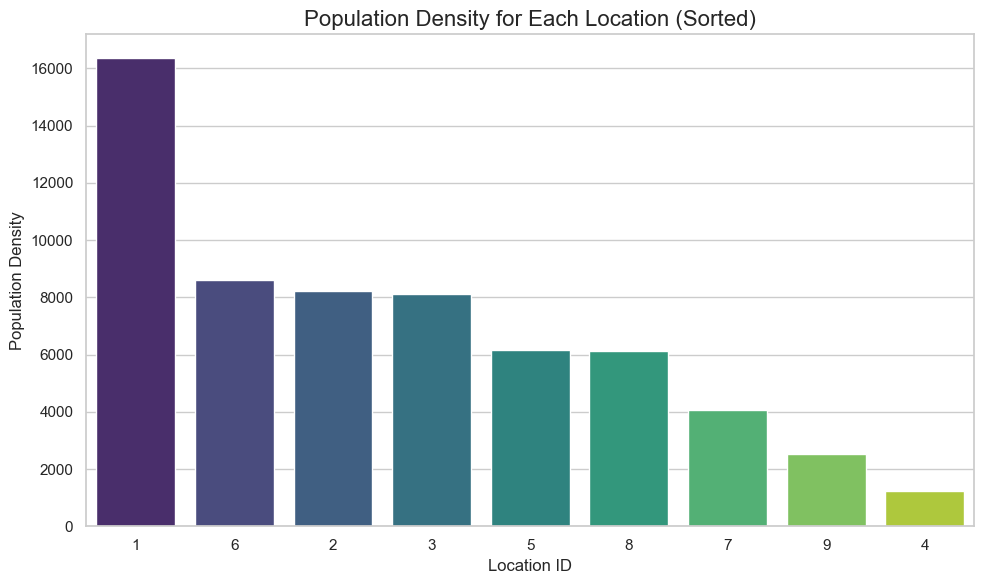

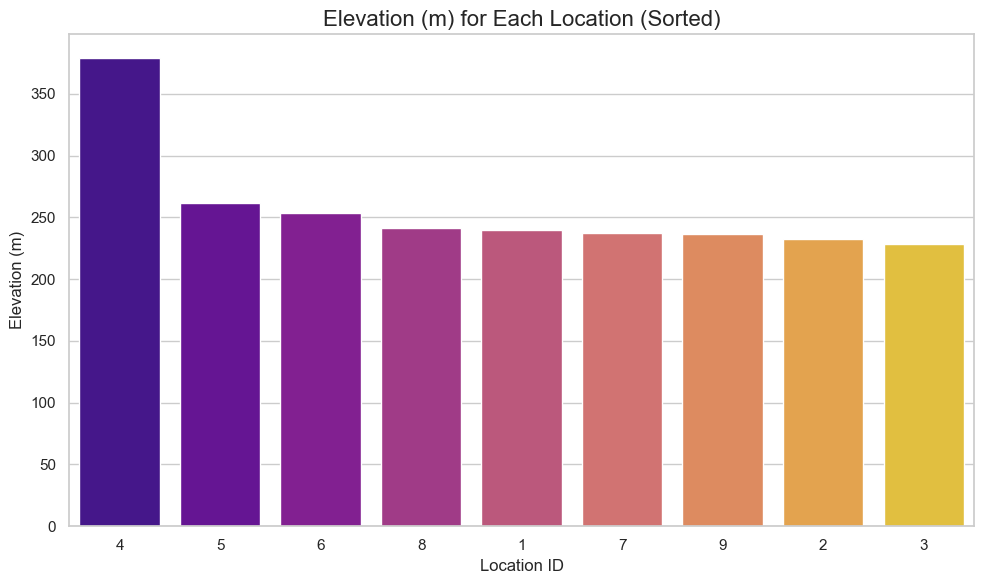

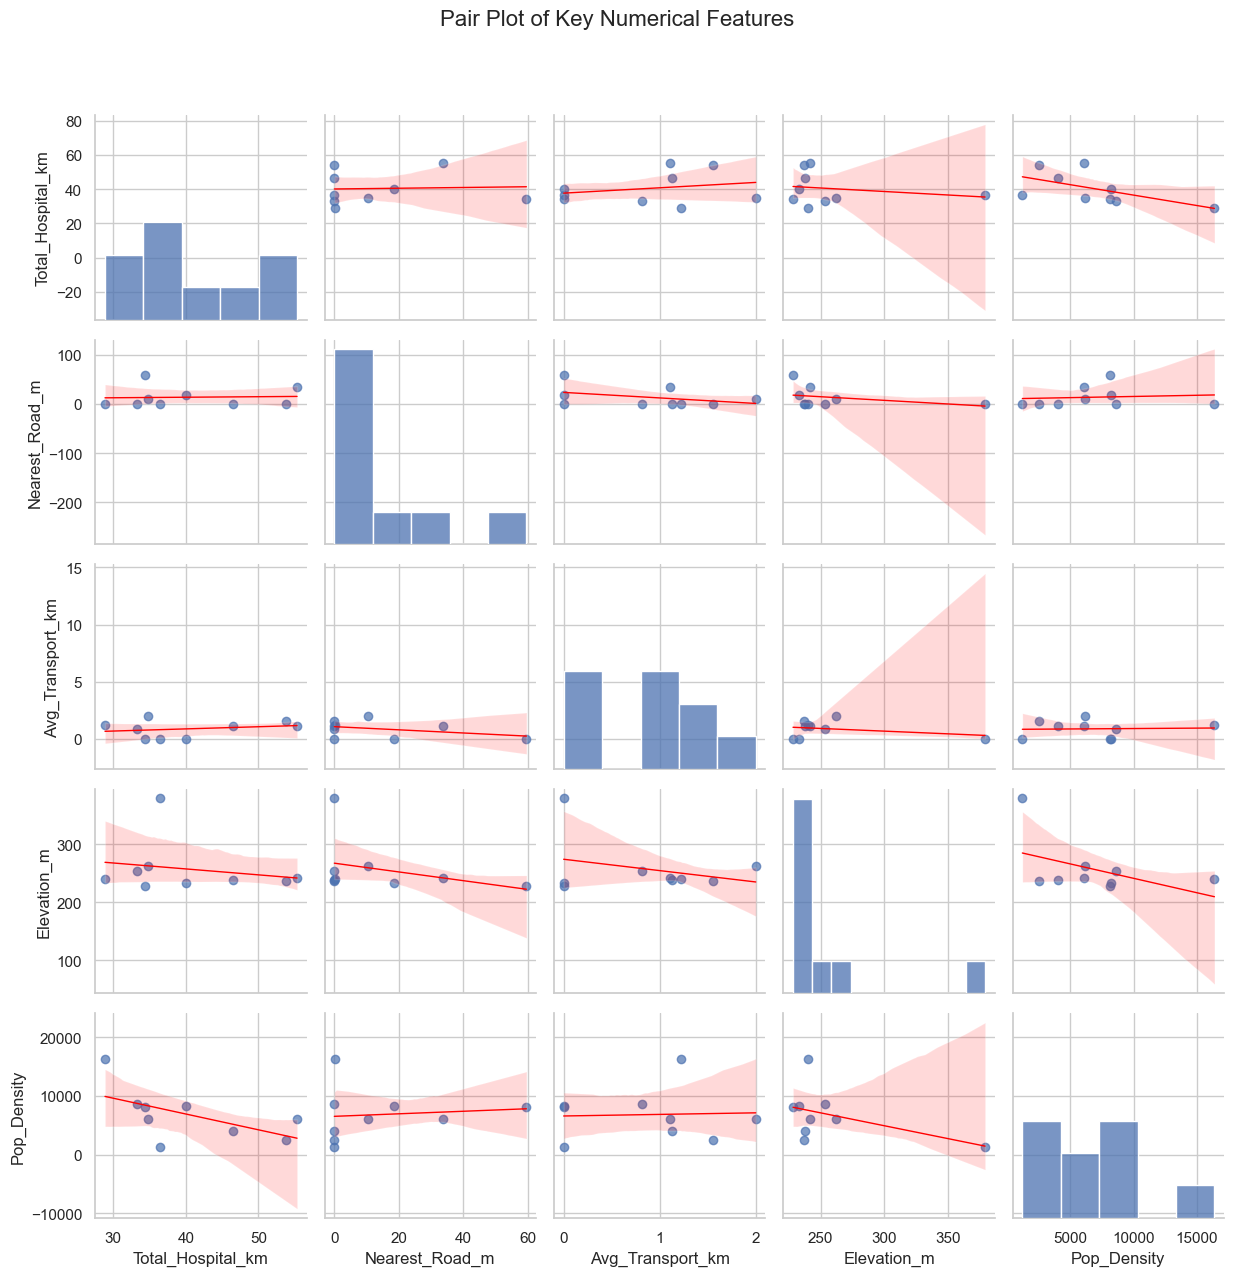

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (using the original 'data.csv' name)
df = pd.read_csv("location_analysis_results.csv")

# Set the theme for a clean look
sns.set_theme(style="whitegrid")

# --- Plot 1: Bar Chart - Population Density by ID (Sorted) ---
df_sorted_pop = df.sort_values('Pop_Density', ascending=False)

plt.figure(figsize=(10, 6))
# CORRECTED LINE: Assign 'x' to 'hue' and set legend=False
sns.barplot(
    data=df_sorted_pop, 
    x=df_sorted_pop['ID'].astype(str), 
    y='Pop_Density', 
    palette='viridis',
    hue=df_sorted_pop['ID'].astype(str),  # <-- This is the fix
    legend=False                          # <-- This is the fix
)
plt.title('Population Density for Each Location (Sorted)', fontsize=16)
plt.xlabel('Location ID', fontsize=12)
plt.ylabel('Population Density', fontsize=12)
plt.tight_layout()
plt.show() # <-- Changed to display the plot

# --- Plot 2: Bar Chart - Elevation by ID (Sorted) ---
df_sorted_elevation = df.sort_values('Elevation_m', ascending=False)

plt.figure(figsize=(10, 6))
# CORRECTED LINE: Assign 'x' to 'hue' and set legend=False
sns.barplot(
    data=df_sorted_elevation, 
    x=df_sorted_elevation['ID'].astype(str), 
    y='Elevation_m', 
    palette='plasma',
    hue=df_sorted_elevation['ID'].astype(str), # <-- This is the fix
    legend=False                         # <-- This is the fix
)
plt.title('Elevation (m) for Each Location (Sorted)', fontsize=16)
plt.xlabel('Location ID', fontsize=12)
plt.ylabel('Elevation (m)', fontsize=12)
plt.tight_layout()
plt.show() # <-- Changed to display the plot

# --- Plot 3: Pair Plot ---
pair_cols = ['Total_Hospital_km', 'Nearest_Road_m', 'Avg_Transport_km', 'Elevation_m', 'Pop_Density']

pair_plot = sns.pairplot(df[pair_cols], kind='reg', plot_kws={'line_kws':{'color':'red', 'lw':1}, 'scatter_kws': {'alpha': 0.7}})
pair_plot.fig.suptitle('Pair Plot of Key Numerical Features', y=1.02, fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show() # <-- Changed to display the plot

# Model Building 

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

latitude = 12.92
longitude = 79.13

end_date = datetime.now().date()
start_date = end_date - timedelta(days=365)

url = (
    "https://air-quality-api.open-meteo.com/v1/air-quality?"
    f"latitude={latitude}&longitude={longitude}"
    f"&start_date={start_date}&end_date={end_date}"
    "&hourly=pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,"
    "sulphur_dioxide,ozone,us_aqi"
)

print(f"Fetching data from {start_date} to {end_date} for Vellore...")


response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    hourly = data["hourly"]

    df = pd.DataFrame({
        "time": hourly["time"],
        "PM10": hourly["pm10"],
        "PM2.5": hourly["pm2_5"],
        "CO": hourly["carbon_monoxide"],
        "NO2": hourly["nitrogen_dioxide"],
        "SO2": hourly["sulphur_dioxide"],
        "O3": hourly["ozone"],
        "US_AQI": hourly["us_aqi"]
    })

    # --- Save to CSV ---
    file_name = f"vellore_air_quality_past_year.csv"
    df.to_csv(file_name, index=False)

    print(f"✅ Saved {len(df)} hourly records to '{file_name}'")
    print(df.head())
else:
    print(f"❌ Failed to fetch data: {response.status_code}")


Fetching data from 2024-11-05 to 2025-11-05 for Vellore...
✅ Saved 8784 hourly records to 'vellore_air_quality_past_year.csv'
               time  PM10  PM2.5     CO   NO2  SO2    O3  US_AQI
0  2024-11-05T00:00  29.3   19.3  528.0  13.3  8.4  19.0      64
1  2024-11-05T01:00  31.7   20.9  484.0  11.0  8.2  33.0      64
2  2024-11-05T02:00  33.8   21.7  443.0   7.7  7.9  52.0      65
3  2024-11-05T03:00  34.0   21.0  398.0   5.0  7.3  70.0      65
4  2024-11-05T04:00  35.5   21.7  340.0   3.3  6.0  86.0      66


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
import numpy as np


df = pd.read_csv("p_data.csv")


X = df[["PM10", "PM2.5", "CO", "NO2", "SO2", "O3"]]
y = df["US_AQI"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators=200, random_state=42),
   
}


results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    results.append([name, round(r2, 4), round(mae, 4), round(rmse, 4)])

results_df = pd.DataFrame(results, columns=["Model", "R² Score", "MAE", "RMSE"])
results_df = results_df.sort_values(by="R² Score", ascending=False).reset_index(drop=True)

print("\n📊 Model Performance Comparison:\n")

pd.DataFrame(results_df)



📊 Model Performance Comparison:



,Model,R² Score,MAE,RMSE
0,Extra Trees,0.8758,9.4001,12.2142
1,Random Forest,0.8679,9.7318,12.5969
2,Gradient Boosting,0.8410,11.0097,13.8225
3,Decision Tree,0.7356,12.7086,17.8219


Dataset Shape: (8784, 8)

Dataset Head:
                time  PM10  PM2.5     CO   NO2  SO2    O3  US_AQI
0  2024-11-05T00:00  29.3   19.3  528.0  13.3  8.4  19.0      64
1  2024-11-05T01:00  31.7   20.9  484.0  11.0  8.2  33.0      64
2  2024-11-05T02:00  33.8   21.7  443.0   7.7  7.9  52.0      65
3  2024-11-05T03:00  34.0   21.0  398.0   5.0  7.3  70.0      65
4  2024-11-05T04:00  35.5   21.7  340.0   3.3  6.0  86.0      66


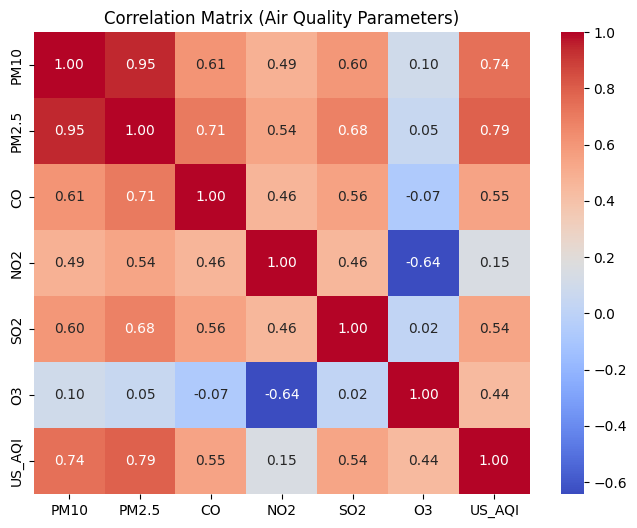

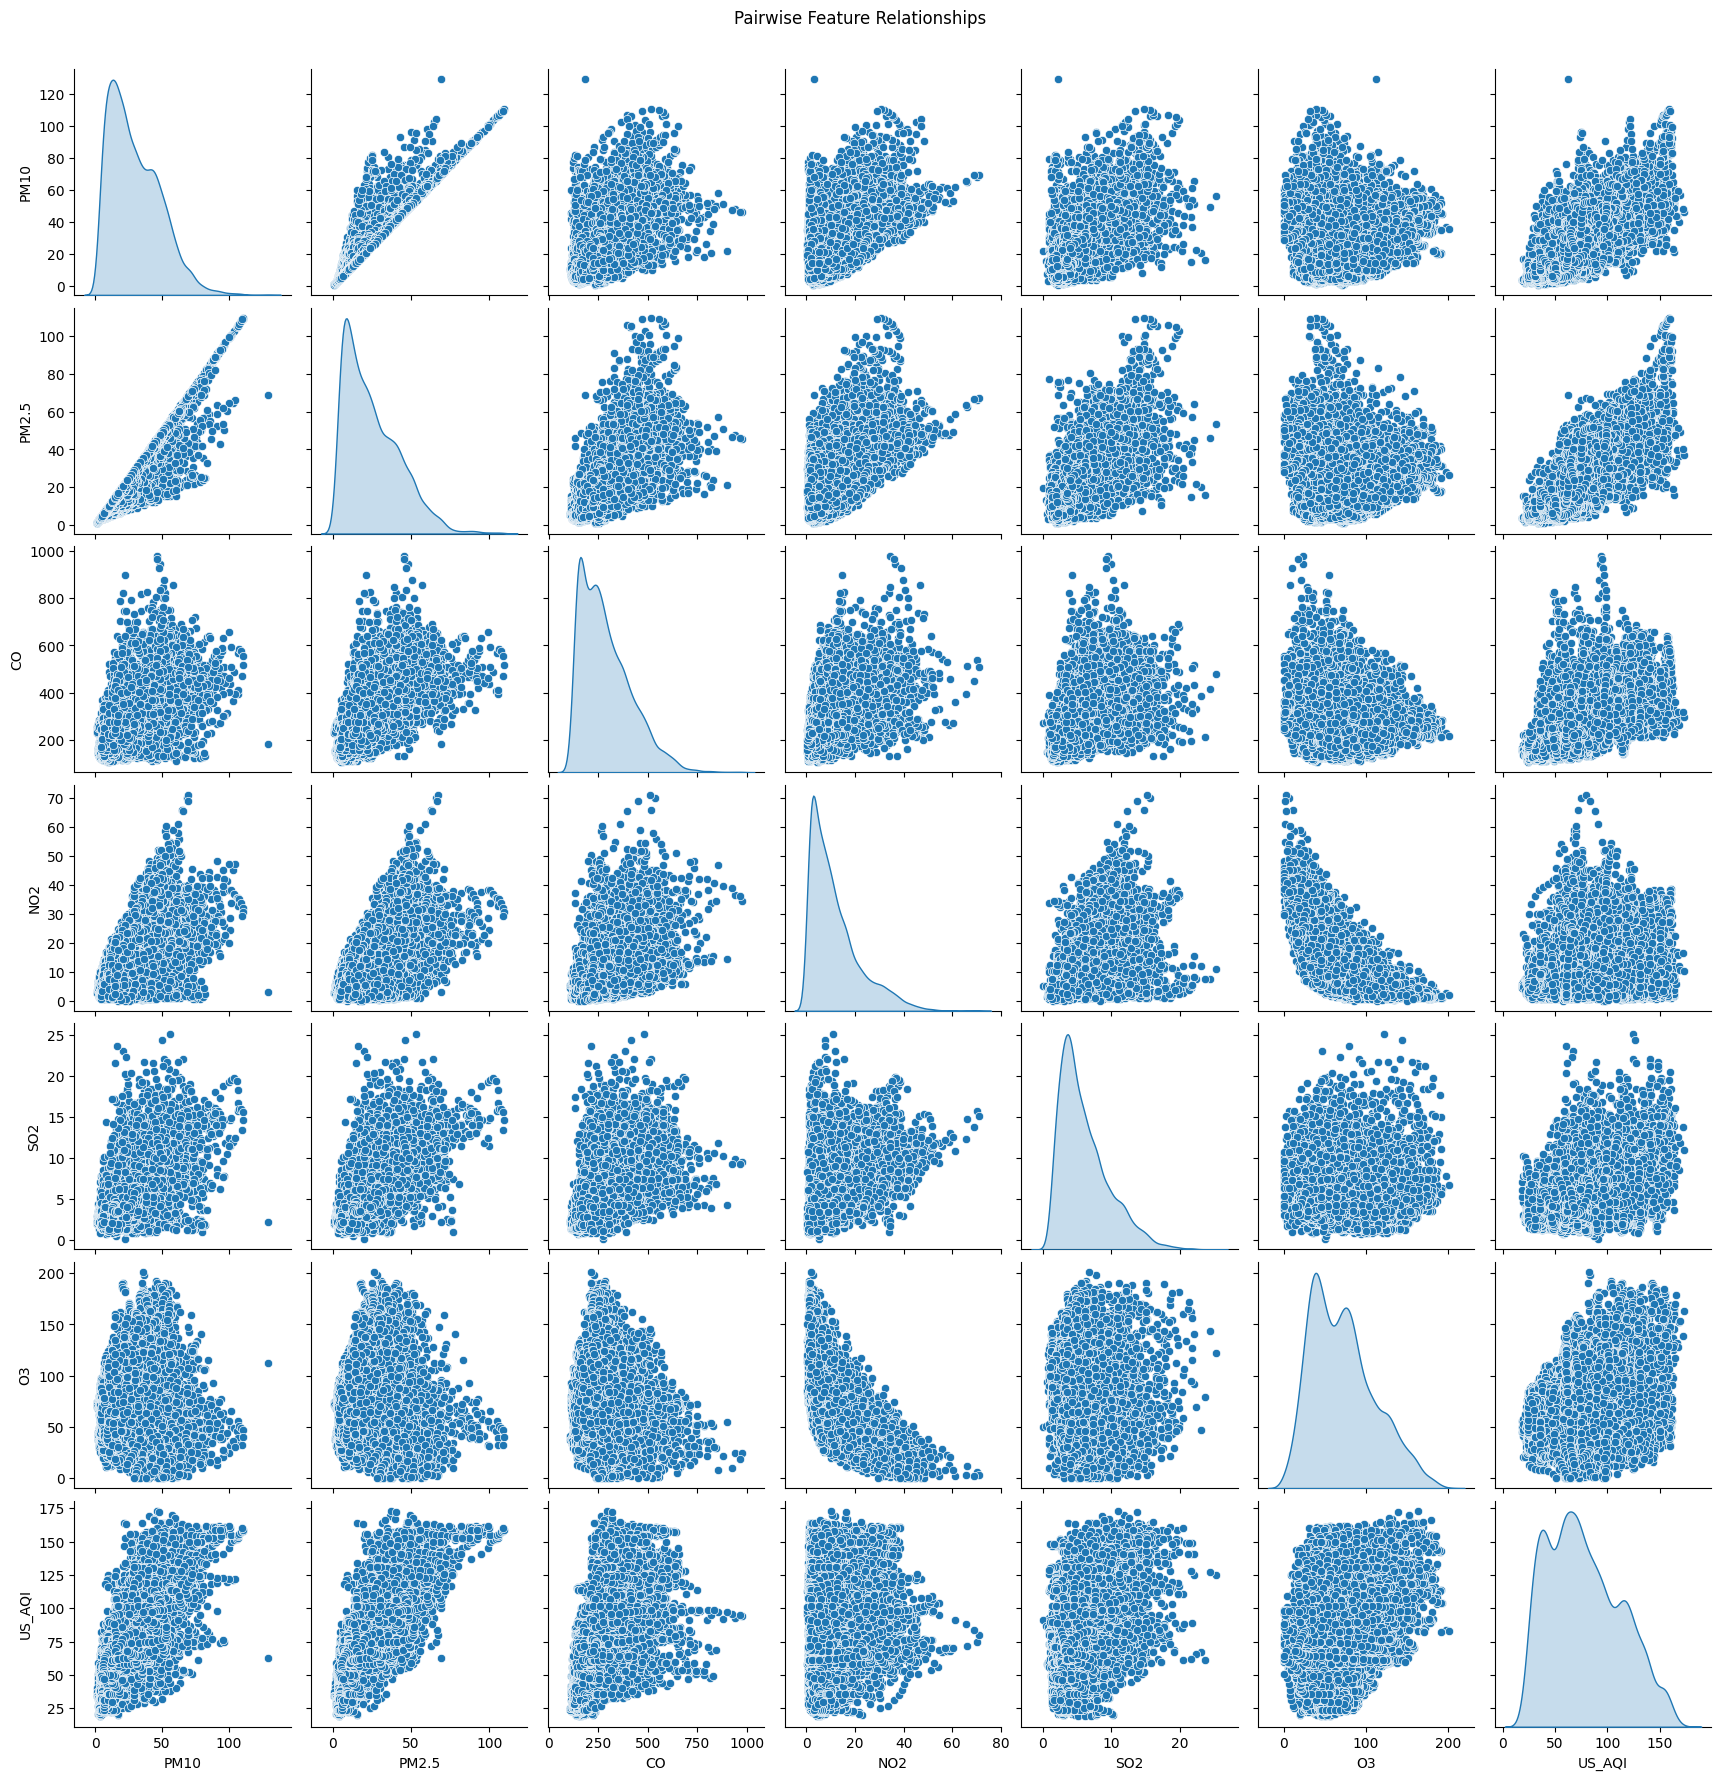


✅ XGBoost Model Performance:
R² Score: 0.8590
MAE: 10.3025
RMSE: 13.0141


C:\Users\kamas\AppData\Local\Temp\ipykernel_16616\1944038737.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance, palette="viridis")


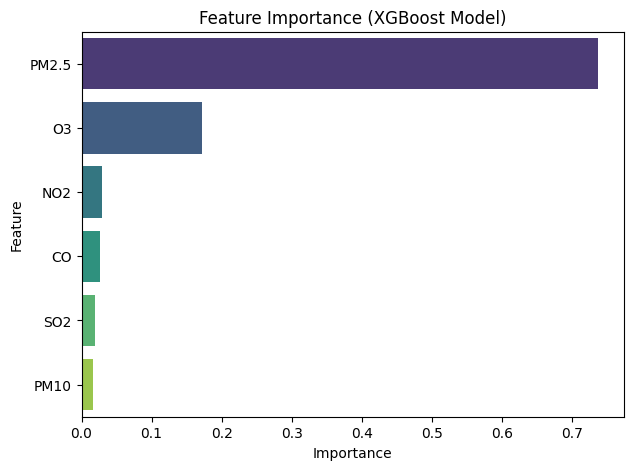

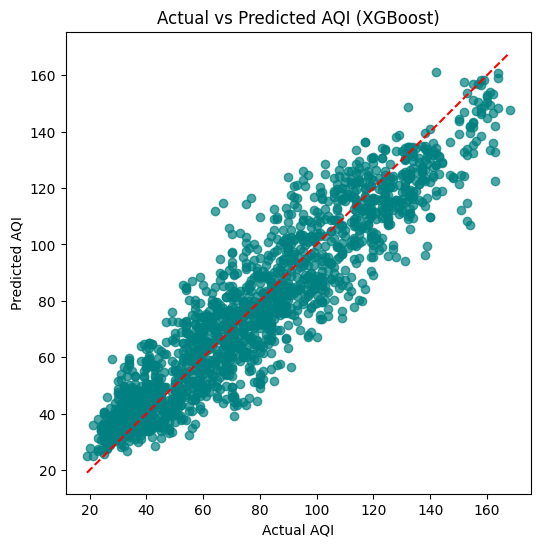


📋 Model Performance Comparison:

                      Model  R² Score      MAE     RMSE
0               Extra Trees    0.8758   9.4001  12.2142
1             Random Forest    0.8679   9.7318  12.5969
2                   XGBoost    0.8590  10.3025  13.0141
3         Gradient Boosting    0.8410  11.0097  13.8225
4             Decision Tree    0.7356  12.7086  17.8219
5  Support Vector Regressor    0.3381  22.4606  28.1988


C:\Users\kamas\AppData\Local\Temp\ipykernel_16616\1944038737.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="R² Score", y="Model", data=results_df, palette="cool")


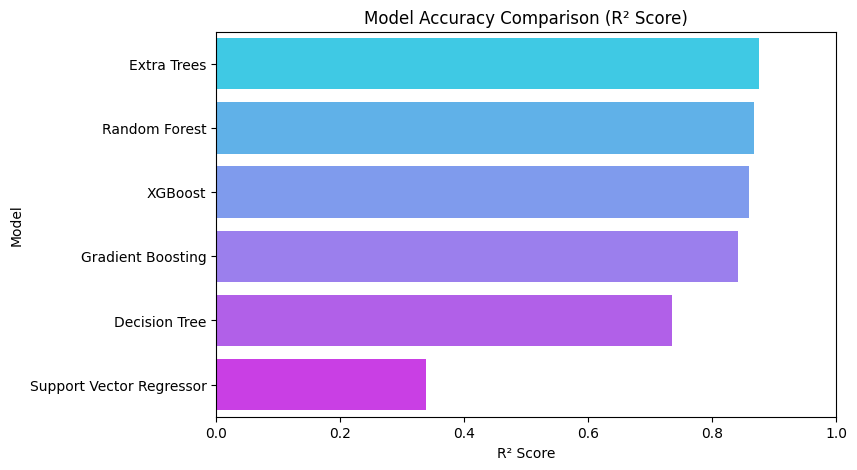

In [8]:
# ================================
#  AIR QUALITY PREDICTION REPORT
# ================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor

# --- Load dataset ---
df = pd.read_csv("p_data.csv")

# --- Display basic info ---
print("Dataset Shape:", df.shape)
print("\nDataset Head:\n", df.head())

# =====================================================
# 📊 1. Correlation Matrix
# =====================================================
plt.figure(figsize=(8,6))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Air Quality Parameters)")
plt.show()

# =====================================================
# 📈 2. Feature Relationships
# =====================================================
sns.pairplot(df, vars=["PM10","PM2.5","CO","NO2","SO2","O3","US_AQI"], diag_kind="kde")
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

# =====================================================
# 🎯 3. Feature Importance Analysis
# =====================================================
X = df[["PM10", "PM2.5", "CO", "NO2", "SO2", "O3"]]
y = df["US_AQI"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train best model (XGBoost)
model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\n✅ XGBoost Model Performance:")
print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# --- Feature importance plot ---
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(7,5))
sns.barplot(x='Importance', y='Feature', data=importance, palette="viridis")
plt.title("Feature Importance (XGBoost Model)")
plt.show()

# =====================================================
# 📉 4. Actual vs Predicted
# =====================================================
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual AQI")
plt.ylabel("Predicted AQI")
plt.title("Actual vs Predicted AQI (XGBoost)")
plt.show()

# =====================================================
# 📊 5. Model Comparison Summary
# =====================================================
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "Extra Trees": ExtraTreesRegressor(n_estimators=200, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42),
    "Support Vector Regressor": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
}

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    results.append([name, round(r2, 4), round(mae, 4), round(rmse, 4)])

results_df = pd.DataFrame(results, columns=["Model", "R² Score", "MAE", "RMSE"])
results_df = results_df.sort_values(by="R² Score", ascending=False).reset_index(drop=True)
print("\n📋 Model Performance Comparison:\n")
print(results_df)

# --- Bar chart for model comparison ---
plt.figure(figsize=(8,5))
sns.barplot(x="R² Score", y="Model", data=results_df, palette="cool")
plt.title("Model Accuracy Comparison (R² Score)")
plt.xlim(0,1)
plt.show()
